In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd
import json

from glob import glob
import os

from importlib import reload

import utils
import persim
import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats

In [2]:
level = 'sub'
normtype = 'both'
stepsize = 3
pxs = 75
nuclei_mask_cutoff = 1
ndims = 3
fs = 15
PP = 6
dpi = 96

sigma = 1
pers_w = 1
pixel_size = 1

Cmap='plasma'
s = 50

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
sbkw = dict(label='', size=pxs, loc='upper left', pad=0.5, color='k', frameon=False, size_vertical=7.5)
sbkw1 = dict(label='', size=pxs/stepsize, loc='upper left', pad=0.5, color='lime', frameon=False, size_vertical=7.5/stepsize)
rtkw = dict(ha='right', va='bottom', c='navy', bbox=dict(facecolor='cornsilk', alpha=0.75, boxstyle=mpl.patches.BoxStyle("Square", pad=0.05)))
sample = 'D2'

wsrc = '..' + os.sep + 'cell_dams' + os.sep
nsrc = '..' + os.sep + 'nuclear_mask' + os.sep
ksrc = '..' + os.sep + 'kde' + os.sep + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = '..' + os.sep + level + 'level' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')
#wcoords = np.asarray(np.nonzero(label == 0))
wcoords = np.loadtxt(ksrc + sample + '_icoords.csv', delimiter=',', dtype=int)
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

smcolumns=['PC 1', 'PC 2', 'N', 'Density', 'N(05G203100)', 'X', 'Y', 'Cell Size', 'Eccentricity']
cnames = ['N', 'Density', 'PC 1', 'PC 2']
k = 0
vs = ['' for _ in range( len(smcolumns)*( len(smcolumns) - 1)//2) ]
for i in range(len(smcolumns)-1):
    for j in range(i+1, len(smcolumns)):
        vs[k] = '{}-vs-{}'.format(smcolumns[i] , smcolumns[j] )
        k += 1
print(vs)

Detected 2937 cells
Detected 1365 nuclei
['PC 1-vs-PC 2', 'PC 1-vs-N', 'PC 1-vs-Density', 'PC 1-vs-N(05G203100)', 'PC 1-vs-X', 'PC 1-vs-Y', 'PC 1-vs-Cell Size', 'PC 1-vs-Eccentricity', 'PC 2-vs-N', 'PC 2-vs-Density', 'PC 2-vs-N(05G203100)', 'PC 2-vs-X', 'PC 2-vs-Y', 'PC 2-vs-Cell Size', 'PC 2-vs-Eccentricity', 'N-vs-Density', 'N-vs-N(05G203100)', 'N-vs-X', 'N-vs-Y', 'N-vs-Cell Size', 'N-vs-Eccentricity', 'Density-vs-N(05G203100)', 'Density-vs-X', 'Density-vs-Y', 'Density-vs-Cell Size', 'Density-vs-Eccentricity', 'N(05G203100)-vs-X', 'N(05G203100)-vs-Y', 'N(05G203100)-vs-Cell Size', 'N(05G203100)-vs-Eccentricity', 'X-vs-Y', 'X-vs-Cell Size', 'X-vs-Eccentricity', 'Y-vs-Cell Size', 'Y-vs-Eccentricity', 'Cell Size-vs-Eccentricity']


In [3]:
exclude_nuclei = True

if exclude_nuclei:
    filenameb = '..' + os.sep + 'translocs' + os.sep + sample + os.sep + 'location_corrected_D2_-_{}.csv'
    ex_nuclei = ''
    pdkw = {'header':None, 'names':['X', 'Y', 'Z']}
else:
    filenameb = '..' + os.sep + 'Bacteria Info for Erik' + os.sep + '{}_v2.txt'
    ex_nuclei = '_w_nucleus'
    pdkw = {'sep':'\t'}

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection' + ex_nuclei + '.csv', transcriptomes, startval=0)

translocs = dict()
for key in transcriptomes:
    filename = filenameb.format(key)
    translocs[key] = pd.read_csv(filename, **pdkw)
    translocs[key]['cidx'] = label[ translocs[key]['Y'], translocs[key]['X'] ]
    translocs[key]['nidx'] =  lnuc[ translocs[key]['Y'], translocs[key]['X'] ]
tlocs = pd.concat(translocs)
zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ 5 ]]), Cells]
#transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ :2 ]]), Cells]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')
genes = '_-_'.join(sorted([ g.replace('GLYMA_', 'Glyma.') for g in ratios.index ]))
print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by both:	5.96%


,169,188,199,209,224,227,233,235,236,243,...,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_05G203100,3,21,0,0,0,0,0,3,2,1,...,1,0,1,0,13,0,1,0,0,0


In [4]:
SCALE = 8
bw = 10

foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
jsonfiles = dict()
for t in transfocus.index:
    jsonfiles[t] = [ foo.format(gsrc, t, t, level, PP, stepsize, bw, Cells[i]) for i in range(ratios.shape[1]) ]

orig_diags = utils.get_diagrams(jsonfiles, ndims, remove_inf=True)
diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
maxxlife = max( list(map(np.max, iter(maxlife.values()))) )

kde_max = np.zeros(ratios.size); i = 0
for gene in diags:
    for cidx in diags[gene]:
        if len(diags[gene][cidx][2]) > 0:
            kde_max[i] = np.max(diags[gene][cidx][2])
            i += 1
kmax = np.sort(kde_max)[-10]

maxbirth = 0
lt_diags = dict()
for gene in diags:
    lt_diags[gene] = dict()
    for cidx in diags[gene]:
        lt_diags[gene][cidx] = [ None for _ in range(len(diags[gene][cidx])) ]
        for k in range(len(diags[gene][cidx])): 
            foo = rescale*diags[gene][cidx][k].copy()
            lt_diags[gene][cidx][k] = np.column_stack( (foo[:,0], foo[:,1] - foo[:,0]) )
            if (len(lt_diags[gene][cidx][k]) > 0) and (lt_diags[gene][cidx][k][:,0].max() > maxbirth):
                maxbirth = lt_diags[gene][cidx][k][:,0].max()
print(list(map(len, iter(lt_diags.values()))), maxbirth)

Initial number of life-birth pairs	: 7159

No. of diagrams s.t. H_k had the most persistent component
H_0:	0 [ 0.0% ]
H_1:	0 [ 0.0% ]
H_2:	441 [ 48.0% ]

Will focus just on dimension k = 2

[441] 4.064895185805458


# Bring in persistence images to the party

In [27]:
sigma = 1
persw = 1
pixsz = 1
iqr_factor = 1.5

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxxlife + sigma))])),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
print(extent)

full_img = dict()
for gene in lt_diags:
    full_img[gene] = dict()
    for cidx in lt_diags[gene]:
        full_img[gene][cidx] = np.asarray( [ pimgr.transform( lt_diags[gene][cidx][k] , skew=False) 
                                            for k in range(len(lt_diags[gene][cidx])) ])
        full_img[gene][cidx][ full_img[gene][cidx] < 0 ] = 0

bname = isrc + '{}_bw{}_{}level'.format(genes.replace('Glyma.',''), bw, level) + os.sep + 'PI_scale{}_'.format(SCALE)
Bname = genes + ' PIs: KDE bandwidth {}. {}level persistence. Scale {}'.format(bw, level.title(), SCALE)
print(bname, Bname, sep='\n')

[0 6 0 8]
../infected_focus_summer24/D2/05G203100_bw10_sublevel/PI_scale8_
Glyma.05G203100 PIs: KDE bandwidth 10. Sublevel persistence. Scale 8


# Pipeline figure

In [28]:
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
embedding = pd.read_csv(bname + 'pca.csv')
zero_val = embedding.iloc[-1, 2:].values
zs = [0, 0, zero_val[0], zero_val[1]]
embedding = embedding.iloc[:-1]
pca = embedding.iloc[:,2:4].values

In [29]:
reload(utils)
steps = 2
reps = np.arange(100)
while len(reps) > 20:
    _, _, grid0, minmask0, _ = utils.grid_representatives(pca, pca, steps)
    nrow, ncol, grid, minmask, reps = utils.grid_representatives(grid0[minmask0], pca, steps)
    steps -= 0.05

Ns = transcell.loc[gene, embedding.loc[reps, 'ndimage_ID'].values].values
rhos = Ns/metacell.loc[embedding.loc[reps, 'ndimage_ID'], 'cyto_area'].values
expo = (np.floor(np.log10(rhos))).astype(int)
base = np.round(rhos*np.power(10., -expo),1)

print(steps, nrow, ncol, len(reps), sep='\t')

1.95	9	31	16


../infected_focus_summer24/D2/05G203100_bw10_sublevel/PI_scale8_H1+2_pca_gridded


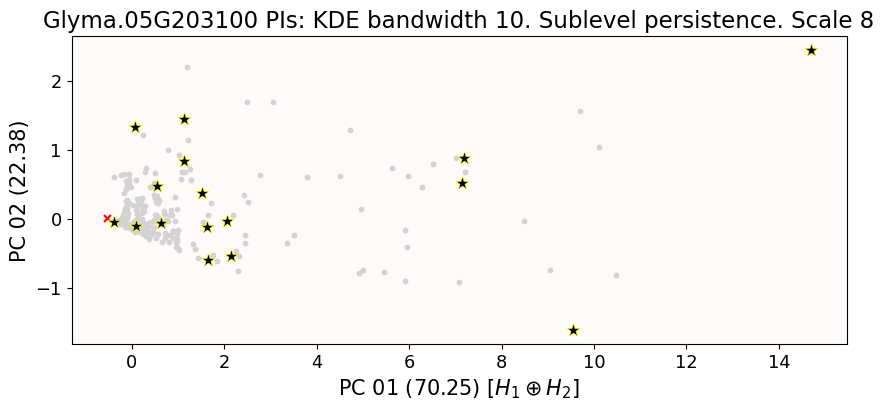

In [30]:
fig, ax = plt.subplots( 1, 1, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=1.1*fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
#ax[i].scatter(grid[minmask,0], grid[minmask,1], c='b', marker='+', s=25, alpha=1, zorder=2)
ax[i].scatter(*zero_val[:2], c='r', marker='x', s=25, alpha=1, zorder=3)
ax[i].scatter(pca[ reps,0], pca[ reps,1], c='k', marker='*', s=100, alpha=1, zorder=4, edgecolor='yellow', linewidth=0.5)
ax[i].set_xlabel(embedding.columns[2]+Pname, fontsize=fs)
ax[i].set_ylabel(embedding.columns[3], fontsize=fs)
ax[i].tick_params(labelsize=0.85*fs)
ax[i].set_facecolor('snow')
#ax[i].set_aspect('equal')

filename = bname + pname + '_pca_gridded'
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')
#plt.savefig(filename + '.svg', bbox_inches='tight', format='svg')

In [11]:
lt_coll = [None for _ in range(len(reps))]
img = np.zeros((len(reps), len(hdims)*extent[1], extent[3]))

for i in range(len(lt_coll)):
    gene, cidx = embedding.loc[reps[i], ['gene', 'ndimage_ID']]
    lt_coll[i] = np.vstack([ np.array([(k-1)*extent[1], 0]) + lt_diags[gene][cidx][k] for k in hdims ])    
    img[i] = np.vstack(full_img[gene][cidx][hdims])
vmax = np.quantile(img[img > 0], 0.99)

../infected_focus_summer24/D2/05G092200_bw25_sublevel/PI_scale24_PI_sample.png


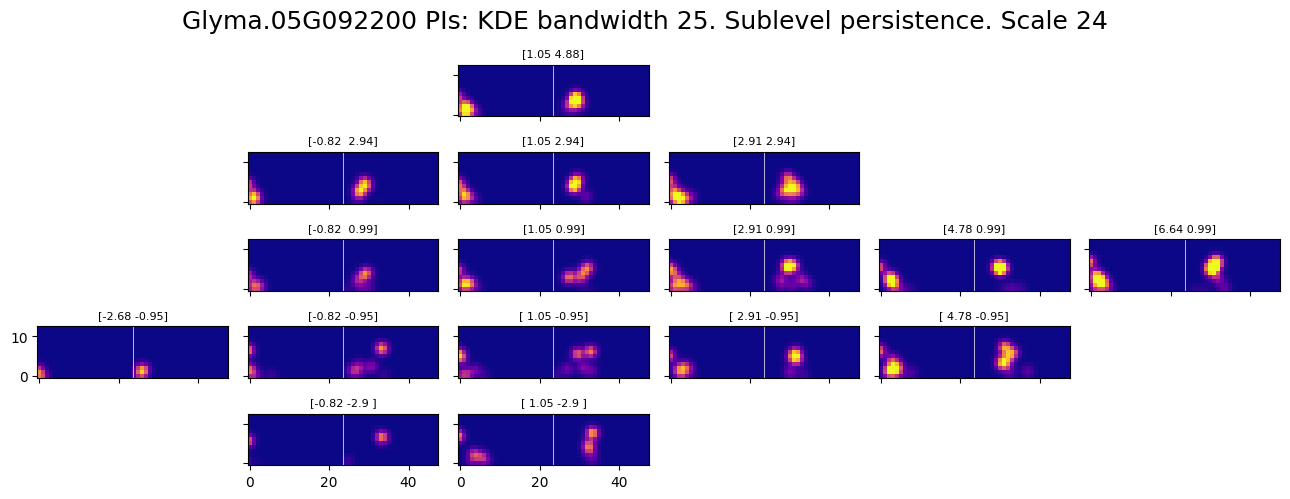

In [11]:
fig, ax = plt.subplots( nrow, ncol, figsize=(13, (0+0.5*len(hdims))*nrow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(img[i].T, cmap=Cmap, vmin=0, vmax=vmax, origin='lower')
    for k in range(1, len(hdims)):
        ax[j].axvline(k*extent[1] - .5, c='white', lw=0.5)
    #ax[j].scatter(lt_coll[i][:,0], lt_coll[i][:,1], c='w', marker='o', s=10, edgecolor='k', linewidth=0.5)
    ax[j].set_title(np.round(grid[minmask][i],2), fontsize=8)

for j in np.nonzero(~minmask)[0]:
    fig.delaxes(ax[j])

fig.suptitle(Bname, fontsize=1.2*fs)
fig.tight_layout();
filename = bname + 'PI_sample.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

In [12]:
hkdes, hcells, hcoords, hextent = [ [None for _ in range(len(reps))] for _ in range(4) ]

for i in range(len(hkdes)):
    gene, cidx = embedding.loc[reps[i], ['gene', 'ndimage_ID']]
    hcoords[i] = translocs[gene].loc[ translocs[gene]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=6)
    s_ = (np.s_[hextent[i][2]:hextent[i][3]], np.s_[hextent[i][0]:hextent[i][1]])
    
    axes, kgrid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], label[s_], hextent[i], zmax, stepsize, cell_nuc, exclude_nuclei=exclude_nuclei)
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(kgrid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
    
    hkdes[i] = np.max(kde * ratios.loc[gene,cidx], axis=0)
    
    if i%10 == 0:
        print(i)

0
10


../infected_focus_summer24/D2/17G195900_bw10_sublevel/PI_scale8_cell_sample.png


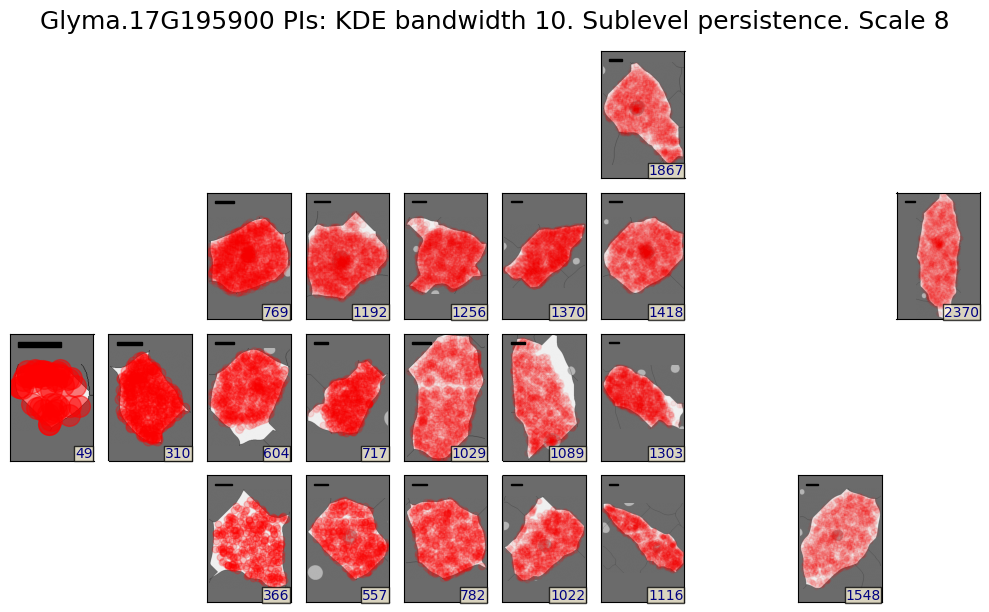

In [13]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[j].scatter(*hcoords[i][:2], color='r', marker='o', alpha=min([0.5,75/Ns[i]]) , s=int(4e6/hcells[i].size))
    ax[j].set_facecolor(wong[2])
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[j].set_aspect('equal','datalim')
    ax[j].text(0.99,0, Ns[i], transform=ax[j].transAxes, **rtkw)
    ax[j].add_artist(AnchoredSizeBar(ax[j].transData, **sbkw))

for j in np.nonzero(~minmask)[0]:
    fig.delaxes(ax[j])

fig.suptitle(Bname, fontsize=1.2*fs)
fig.tight_layout();
filename = bname + 'cell_sample.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

../infected_focus_summer24/D2/17G195900_bw10_sublevel/PI_scale8_kde_sample.png


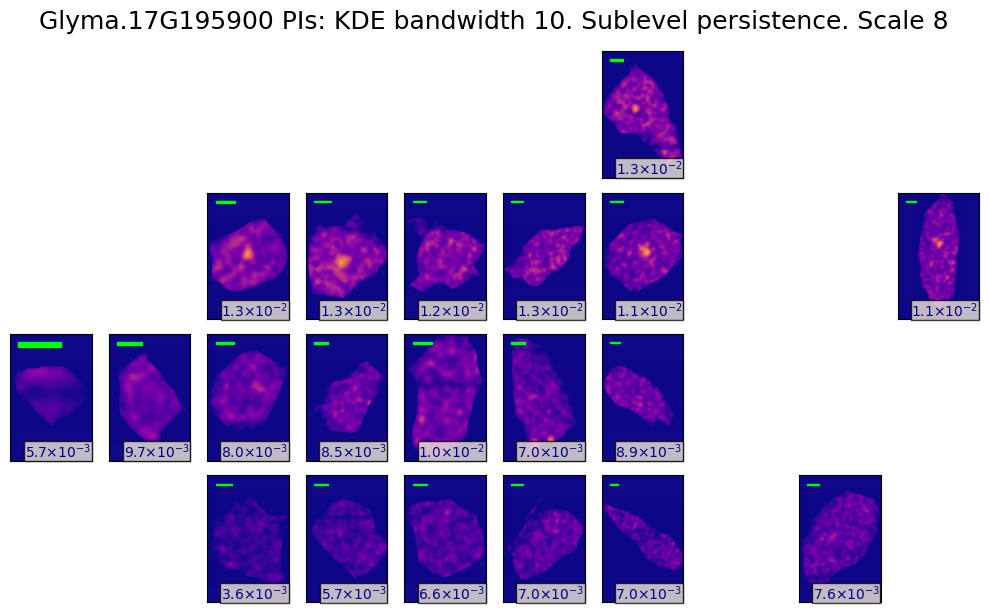

In [14]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hkdes[i], origin='lower', cmap=Cmap, vmin=0, vmax=kmax, zorder=1)
    ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal','datalim')
    ax[j].text(0.99,0, '{:.1f}$\\times$10$^{{{}}}$'.format(base[i], expo[i]), transform=ax[j].transAxes, **rtkw)
    ax[j].add_artist(AnchoredSizeBar(ax[j].transData, **sbkw1))

for j in np.nonzero(~minmask)[0]:
    fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')

fig.suptitle(Bname, fontsize=1.2*fs)
fig.tight_layout();
filename = bname + 'kde_sample.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

# Summarize correlations

In [31]:
cmask = embedding.loc[ embedding['gene'] == ratios.index[0] , 'ndimage_ID' ]
summary0 = embedding.iloc[:, 1:4].copy().set_index('ndimage_ID')
density = transcell.loc[ratios.index[0], Cells] / metacell.loc[Cells, 'cyto_area']
density.name = 'density'
NN = transcell.loc[ratios.index[0], Cells].copy()
NN.name = 'N'
summary0 = summary0.join(pd.concat([NN, density], axis=1), how='outer').join(transcell.loc['GLYMA_05G203100', Cells] + 1)
summary0 = summary0.join(metacell.loc[Cells, ['ndimage_comX','ndimage_comY','cyto_area']], how='outer')
summary0.iloc[ pd.isna(summary0.iloc[:,0]).values , :2] = zero_val[:2]
summary0 = summary0.join(metaecc['eccentricity'].max() - metaecc.loc[Cells, 'eccentricity'])
summary0.columns = smcolumns
print(summary0.shape)
summary0.head()

(918, 9)


,PC 1,PC 2,N,Density,N(05G203100),X,Y,Cell Size,Eccentricity
169,0.027001,-0.169477,3,0.000028,4,7789.38,3043.66,106788,4745.936000
188,2.440412,-0.348471,21,0.000089,22,8140.11,3270.17,236885,4455.824132
199,-0.545467,0.013033,0,0.000000,1,7409.04,3189.21,102388,4677.492017
209,-0.545467,0.013033,0,0.000000,1,8798.15,3142.66,42671,4555.942172
224,-0.545467,0.013033,0,0.000000,1,6297.28,3275.46,79031,4832.496197


In [11]:
crcolumns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr', 'spearson', 'ppearson', 'sspearman', 'pspearman']

corr = pd.DataFrame(index=vs, columns=crcolumns)
corr0 = pd.DataFrame(index=vs, columns=crcolumns)

for idx in corr.index:
    x,y = summary0.loc[ cmask, idx.split('-vs-') ].T.values
    corr.loc[idx, ['sspearman', 'pspearman'] ] = stats.spearmanr(x,y)
    corr.loc[idx, ['spearson', 'ppearson'] ] = stats.pearsonr(x,y)
    c = stats.linregress(x,y)
    corr.loc[idx, ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']] = c
    corr.loc[idx, 'intercept_stderr'] = c.intercept_stderr

    x,y = summary0[ idx.split('-vs-') ].T.values
    corr0.loc[idx, ['sspearman', 'pspearman'] ] = stats.spearmanr(x,y)
    corr0.loc[idx, ['spearson', 'ppearson'] ] = stats.pearsonr(x,y)
    c = stats.linregress(x,y)
    corr0.loc[idx, ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']] = c
    corr0.loc[idx, 'intercept_stderr'] = c.intercept_stderr

In [17]:
filename = bname + 'corr_summary.csv'
print(filename)
corr.head()

../infected_focus_summer24/D2/17G195900_bw10_sublevel/PI_scale8_corr_summary.csv


,slope,intercept,rvalue,pvalue,stderr,intercept_stderr,spearson,ppearson,sspearman,pspearman
PC 1-vs-PC 2,0.026461,0.010294,0.07283,0.027345,0.011973,0.016131,0.07283,0.027345,-0.048442,0.142493
PC 1-vs-N,280.448239,679.997574,0.92181,0.0,3.896671,5.250115,0.92181,0.0,0.925764,0.0
PC 1-vs-Density,0.000349,0.008411,0.172156,0.0,0.000066,0.000089,0.172156,0.0,0.205024,0.0
PC 1-vs-N(05G203100),0.669715,5.275324,0.055375,0.093583,0.398987,0.537568,0.055375,0.093583,0.171562,0.0
PC 1-vs-X,-640.039593,9591.239578,-0.261102,0.0,78.183615,105.33939,-0.261102,0.0,-0.240014,0.0


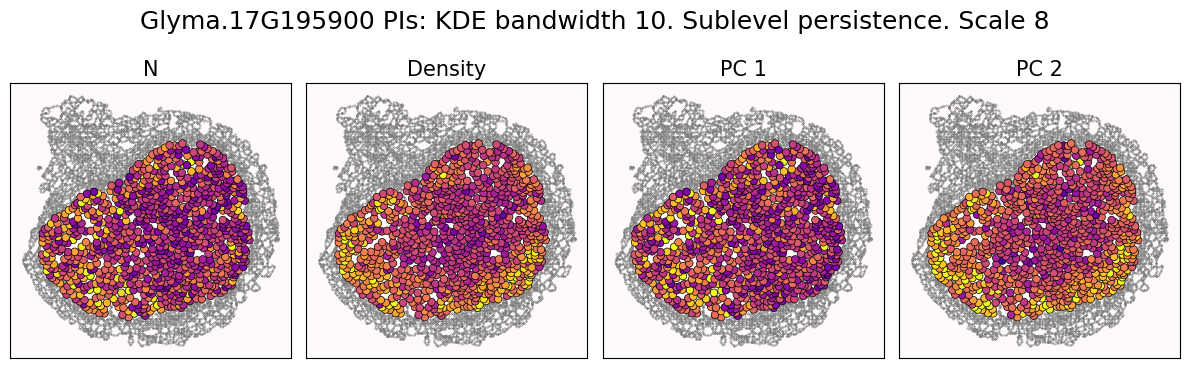

In [18]:
s = 30
fig, ax = plt.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i,cname in enumerate(cnames):
    c = summary0.loc[:, cname]
    zmask = c != zs[i] 
    vmax = utils.maximum_qq_size(c[zmask], alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c[zmask], alpha=0.25, iqr_factor=1.5)
    delta = 0.25*(vmax-vmin)
    vmax += delta

    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
    ax[i].scatter(*summary0.loc[~zmask,['X','Y']].T.values, c='k', marker='D', s=0.75*s, edgecolor='#808080', zorder=2)
    ax[i].scatter(*summary0.loc[zmask,['X','Y']].T.values, c=c[zmask]+delta, marker='o', cmap=Cmap, s=s,
                  edgecolor='k', linewidth=0.5, zorder=3, vmax=vmax, vmin=vmin)
    ax[i].set_aspect('equal')
    ax[i].set_facecolor('snow')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_title(c.name, fontsize=fs)
fig.suptitle(Bname, fontsize=1.2*fs)
fig.tight_layout()

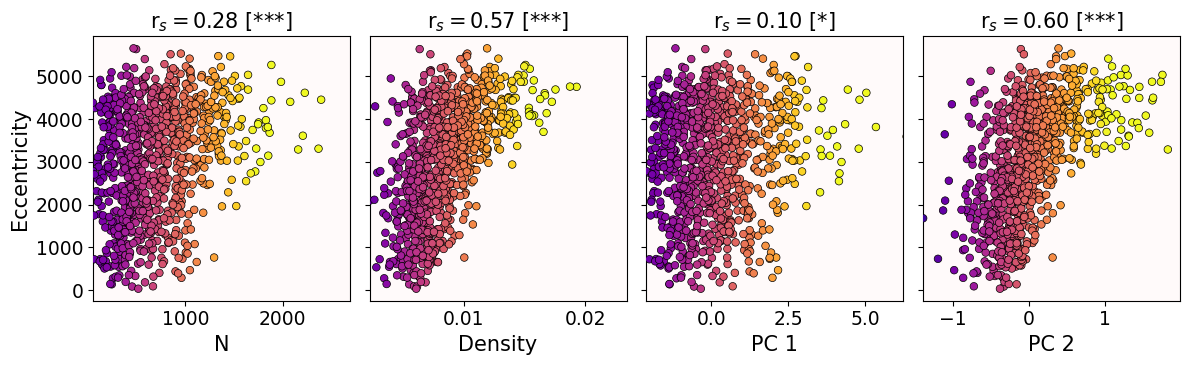

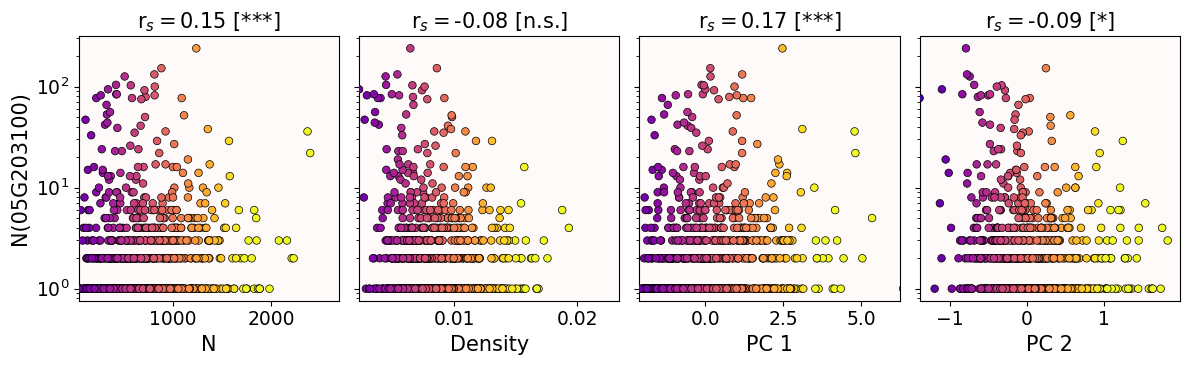

In [19]:
for yaxis,yscale in zip(['Eccentricity', 'N(05G203100)'],['linear','log']):
    ecc = summary0[yaxis]
    fig, ax = plt.subplots(1, 4, figsize=(12,3.75), sharex=False, sharey=True)
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    for i,cname in enumerate(cnames):
        c = summary0.loc[:, cname]
        zmask = c != zs[i] 
        vmax = utils.maximum_qq_size(c[zmask], alpha=0.25, iqr_factor=1.5)
        vmin = utils.minimum_qq_size(c[zmask], alpha=0.25, iqr_factor=1.5)
        delta = 0.25*(vmax-vmin)
        vmax += delta
    
        ax[i].scatter(c[zmask], ecc[zmask], c=c[zmask]+delta, marker='o', cmap=Cmap, s=s,
                      edgecolor='k', linewidth=0.5, zorder=3, vmax=vmax, vmin=vmin)
        ax[i].scatter(c[~zmask], ecc[~zmask], c='k', marker='D', s=s, edgecolor='w', zorder=2)
        ax[i].set_facecolor('snow')
        ax[i].tick_params(labelsize=0.9*fs)
        ax[i].set_xlabel(c.name, fontsize=fs)
        ax[i].set_xlim(c.min(), 1.25*vmax)
        ax[i].set_yscale(yscale)
        r,p = corr.loc[cname + '-vs-' + ecc.name, ['sspearman', 'pspearman'] ]
        ll = 'r$_s = ${:.2f} [{}]'.format(r, utils.star_signif(p, mx=3))
        ax[i].set_title(ll, fontsize=fs)
    ax[0].set_ylabel(ecc.name, fontsize=fs)
    #fig.suptitle(Bname, fontsize=1.2*fs)
    fig.tight_layout()

In [51]:
corr.loc[[cname + '-vs-Eccentricity' for cname in cnames]]

,slope,intercept,rvalue,pvalue,stderr,intercept_stderr,spearson,ppearson,sspearman,pspearman
N-vs-Eccentricity,1.317803,2448.403851,0.263192,0.0,0.159604,86.586867,0.263192,0.0,0.238656,0.0
Density-vs-Eccentricity,160843.26183,2088.215787,0.32997,0.0,15203.685808,101.806402,0.32997,0.0,0.341555,0.0
PC 1-vs-Eccentricity,211.107484,3051.227855,0.278026,0.0,24.099137,40.711444,0.278026,0.0,0.268074,0.0
PC 2-vs-Eccentricity,-206.556682,3095.395256,-0.229455,0.0,28.950014,41.187997,-0.229455,0.0,-0.232891,0.0


In [52]:
corr.loc[[cname + '-vs-N(05G203100)' for cname in cnames]]

,slope,intercept,rvalue,pvalue,stderr,intercept_stderr,spearson,ppearson,sspearman,pspearman
N-vs-N(05G203100),0.008034,1.505506,0.126362,0.000124,0.002084,1.130502,0.126362,0.000124,0.16728,0.0
Density-vs-N(05G203100),-228.520433,6.758646,-0.036921,0.263781,204.367169,1.368476,-0.036921,0.263781,-0.053745,0.103663
PC 1-vs-N(05G203100),1.200982,5.191919,0.124564,0.000155,0.316083,0.53397,0.124564,0.000155,0.076588,0.0203
PC 2-vs-N(05G203100),0.247153,5.331323,0.021622,0.512917,0.377588,0.537205,0.021622,0.512917,0.051469,0.11915


In [23]:
c.name

'PC 2'

N-vs-Eccentricity
Density-vs-Eccentricity
PC 1-vs-Eccentricity
PC 2-vs-Eccentricity


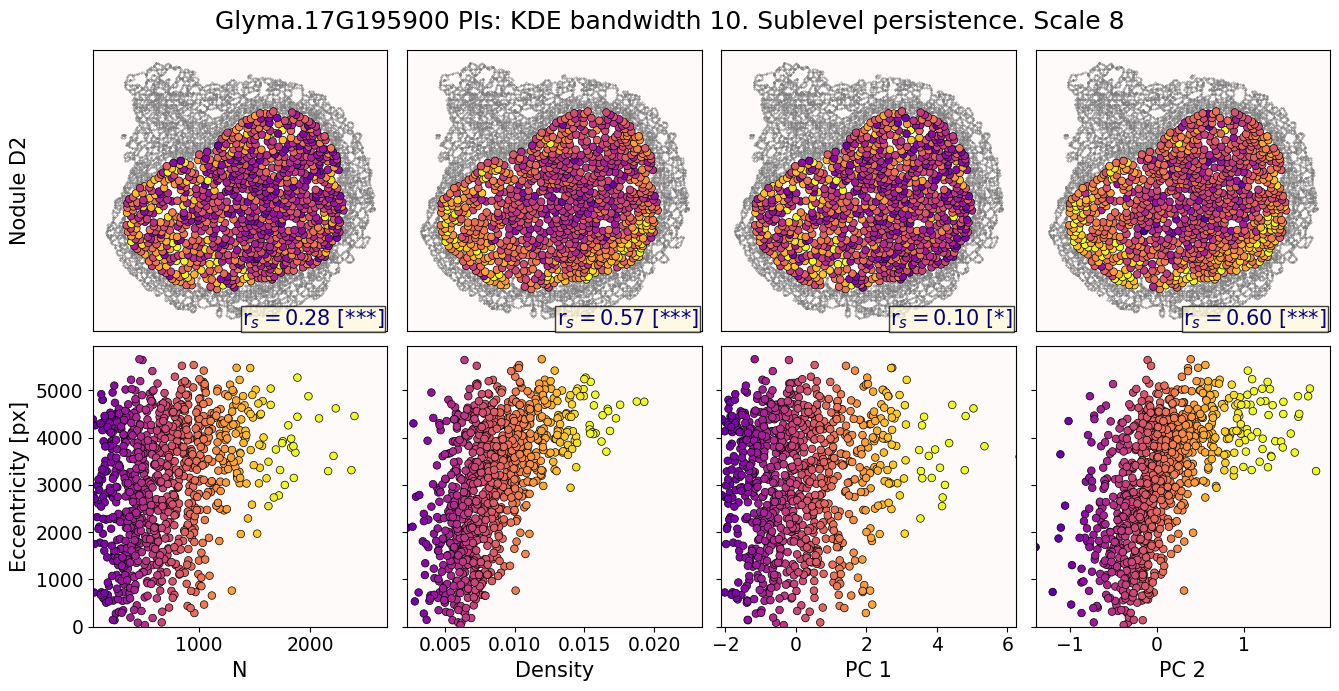

In [29]:
ecc = summary0['Eccentricity']
fig, ax = plt.subplots(2, 4, figsize=(13.5,7), sharex=False, sharey=False)
#ax = np.atleast_1d(ax).ravel(); i = 0

for i,cname in enumerate(cnames):
    j = 0
    c = summary0.loc[:, cname]
    zmask = c != zs[i] 
    vmax = utils.maximum_qq_size(c[zmask], alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c[zmask], alpha=0.25, iqr_factor=1.5)
    delta = 0.25*(vmax-vmin)
    vmax += delta

    ax[j,i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
    ax[j,i].scatter(*summary0.loc[~zmask,['X','Y']].T.values, c='k', marker='D', s=0.75*s, edgecolor='#808080', zorder=2)
    ax[j,i].scatter(*summary0.loc[zmask,['X','Y']].T.values, c=c[zmask]+delta, marker='o', cmap=Cmap, s=s,
                  edgecolor='k', linewidth=0.5, zorder=3, vmax=vmax, vmin=vmin)
    ax[j,i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    r,p = corr.loc[c.name + '-vs-' + ecc.name, ['sspearman', 'pspearman'] ]
    ll = 'r$_s = ${:.2f} [{}]'.format(r, utils.star_signif(p, mx=3))
    ax[j,i].text(0.99,0, ll, transform=ax[j,i].transAxes, fontsize=fs, **rtkw)
    
    j = 1
    ax[j,i].scatter(c[zmask], ecc[zmask], c=c[zmask]+delta, marker='o', cmap=Cmap, s=s, edgecolor='k', linewidth=0.5, vmax=vmax, vmin=vmin)
    ax[j,i].scatter(c[~zmask], ecc[~zmask], c='k', marker='D', s=s, edgecolor='w', zorder=2)
    ax[j,i].set_xlim(c.min(), 1.25*vmax)
    ax[j,i].set_ylim(0, 1.05*ecc.max())
    ax[j,i].tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
    print(c.name + '-vs-' + ecc.name)
    ax[j,i].set_xlabel(c.name, fontsize=fs)

ax[0,0].set_ylabel('Nodule ' + sample, fontsize=fs)
ax[1,0].tick_params(labelleft=True)
ax[1,0].set_ylabel('Eccentricity [px]', fontsize=fs)

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(labelsize=0.9*fs)


fig.align_ylabels()
fig.suptitle(Bname, fontsize=1.2*fs)
fig.tight_layout()

In [28]:
corr.loc[c.name + '-vs-' + ecc.name, ['sspearman', 'pspearman'] ]

sspearman    0.595937
pspearman         0.0
Name: PC 2-vs-Eccentricity, dtype: object

In [27]:
corr.loc[c.name + '-vs-' + ecc.name]

slope               1439.991425
intercept           3060.034342
rvalue                 0.549292
pvalue                      0.0
stderr                72.380799
intercept_stderr      35.320415
spearson               0.549292
ppearson                    0.0
sspearman              0.595937
pspearman                   0.0
Name: PC 2-vs-Eccentricity, dtype: object

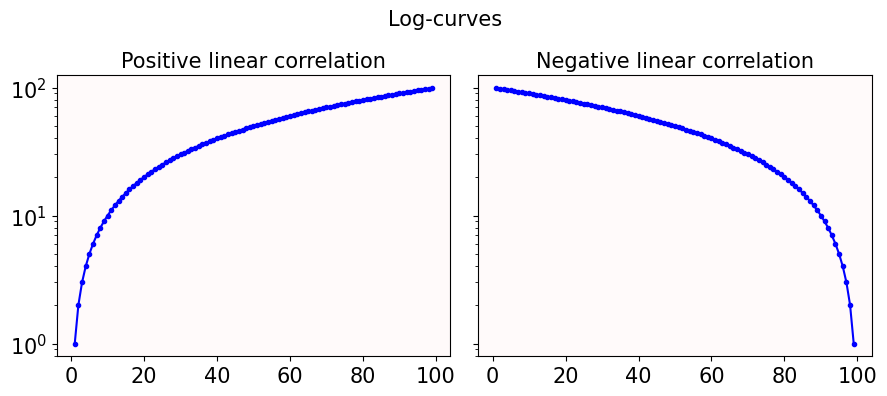

In [13]:
fs = 15
x = np.arange(1,100)
fig, ax = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
ax[0].plot(x,x, marker='.', c='b')
ax[1].plot(x,100-x, marker='.', c='b')
ax[0].set_title('Positive linear correlation', fontsize=fs)
ax[1].set_title('Negative linear correlation', fontsize=fs)
for a in ax.ravel():
    a.set_yscale('log')
    a.set_facecolor('snow')
    a.tick_params(labelsize=fs)

fig.suptitle('Log-curves', fontsize=fs)
fig.tight_layout()
plt.savefig('../manuscript/logcurves.png', format='png', bbox_inches='tight', dpi=96)

# Explore a PCA continuum